In [1]:
import torch
import numpy as np
from torchvision import transforms
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

from point_e.evals.feature_extractor import PointNetClassifier, get_torch_devices
from point_e.evals.fid_is import compute_statistics
from point_e.evals.npz_stream import NpzStreamer

from PIL import Image

import os
import matplotlib.pyplot as plt

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_name = 'base300M' # base40M, use base300M or base1B for better results

MODEL_CONFIGS[base_name]["n_views"] = 1
MODEL_CONFIGS['upsample']["n_views"] = 1

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096-1024], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
downloading base checkpoint...
downloading upsampler checkpoint...


In [3]:
# ---- Evaluation
print("creating classifier...")
clf = PointNetClassifier(devices=get_torch_devices(), cache_dir=None)

creating classifier...


In [101]:
ground_point_clouds = np.load("ground.npz")["arr_0"]
pointe_point_clouds = np.load("gen.npz")["arr_0"]

In [108]:
# ---- Computing distances in batch
features_1, _ = clf.features_and_preds(NpzStreamer("ground.npz"))
stats_1 = compute_statistics(features_1)

features_2, _ = clf.features_and_preds(NpzStreamer("gen.npz"))
stats_2 = compute_statistics(features_2)

### Computing metrics

Clouds distance: 2.28601284604224


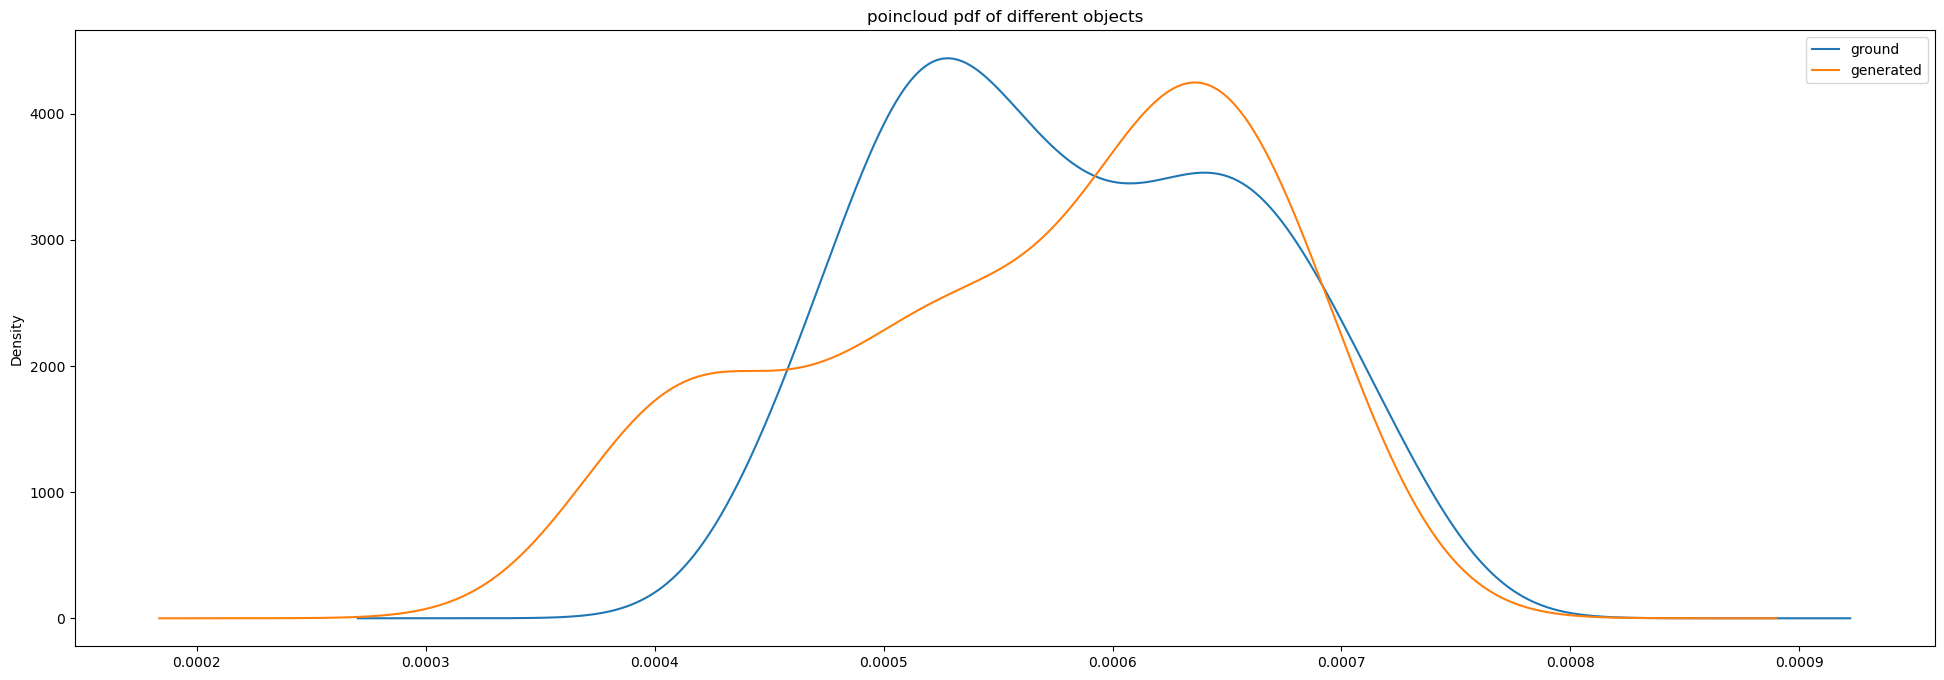

Clouds distance: 1.3748655796064213


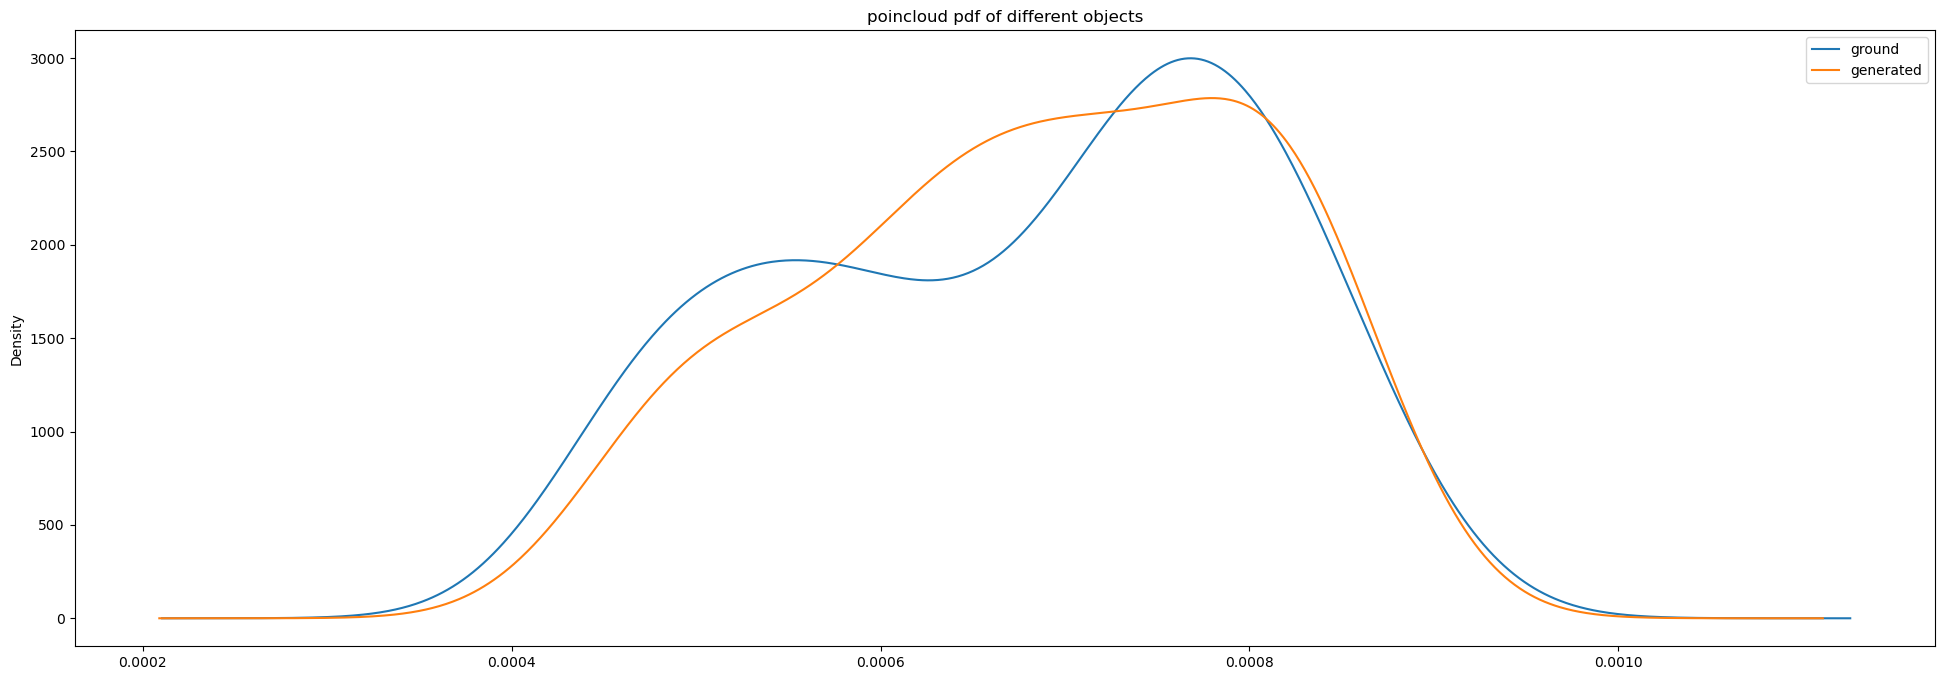

Clouds distance: 2.160506075910007


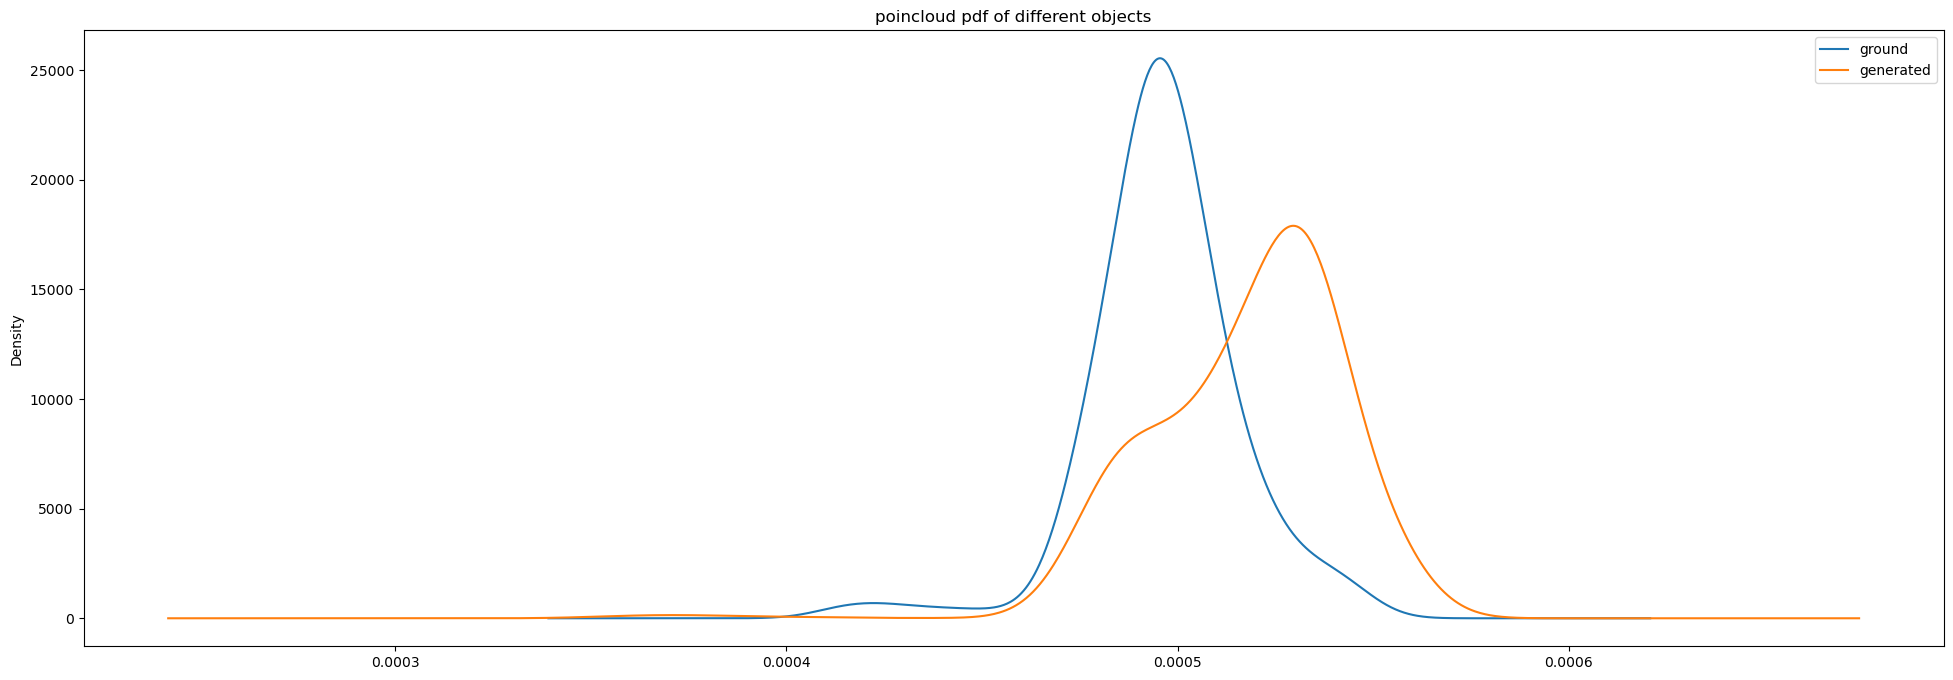

Clouds distance: 1.5478017871828342


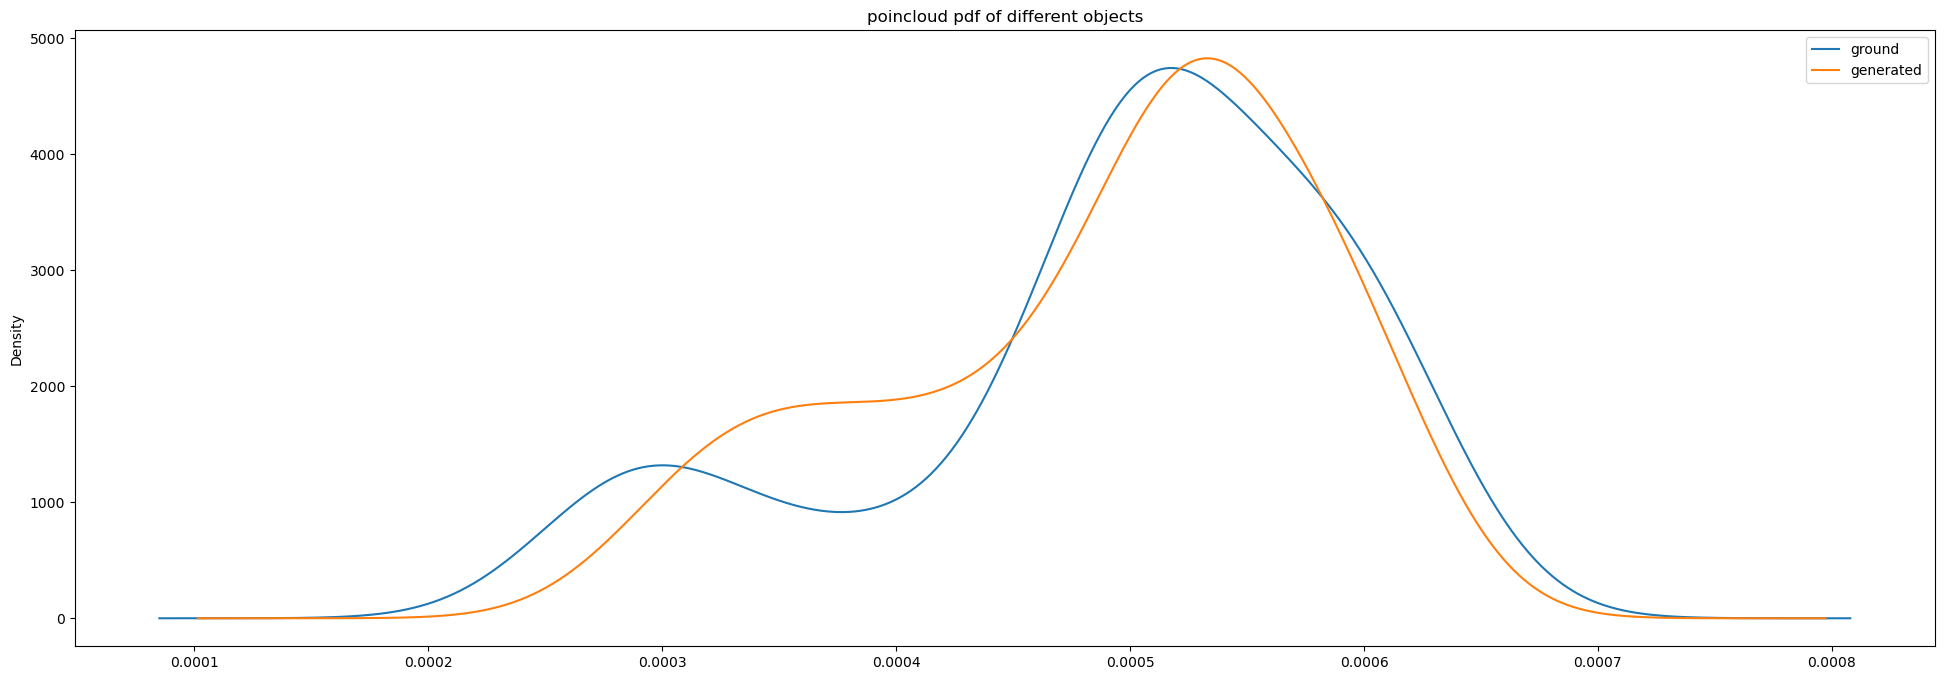

Clouds distance: 0.5522751969522233


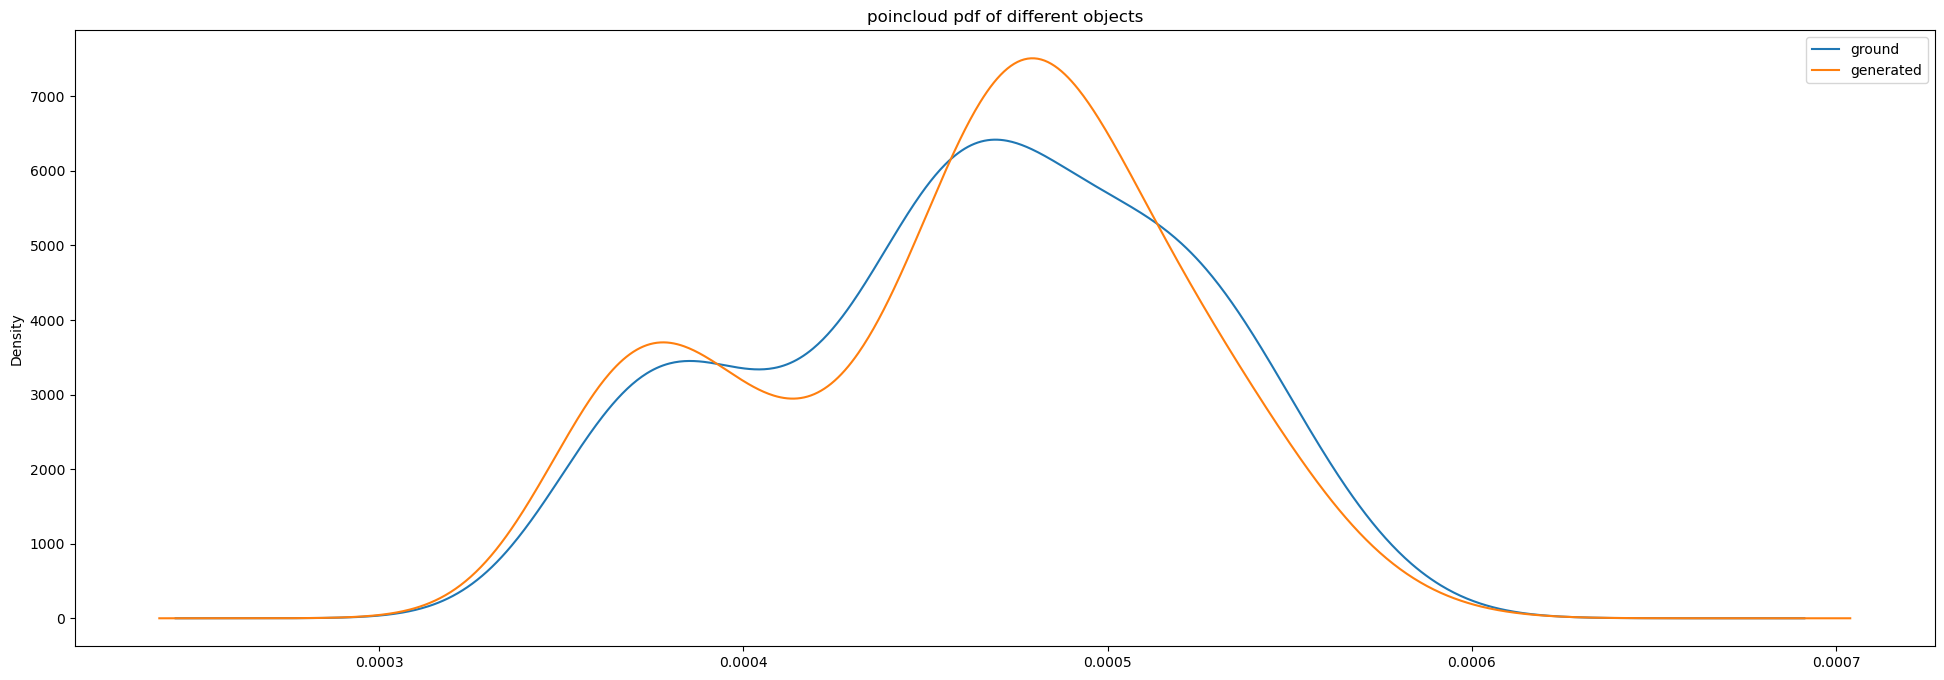

Clouds distance: 4.740887877119349


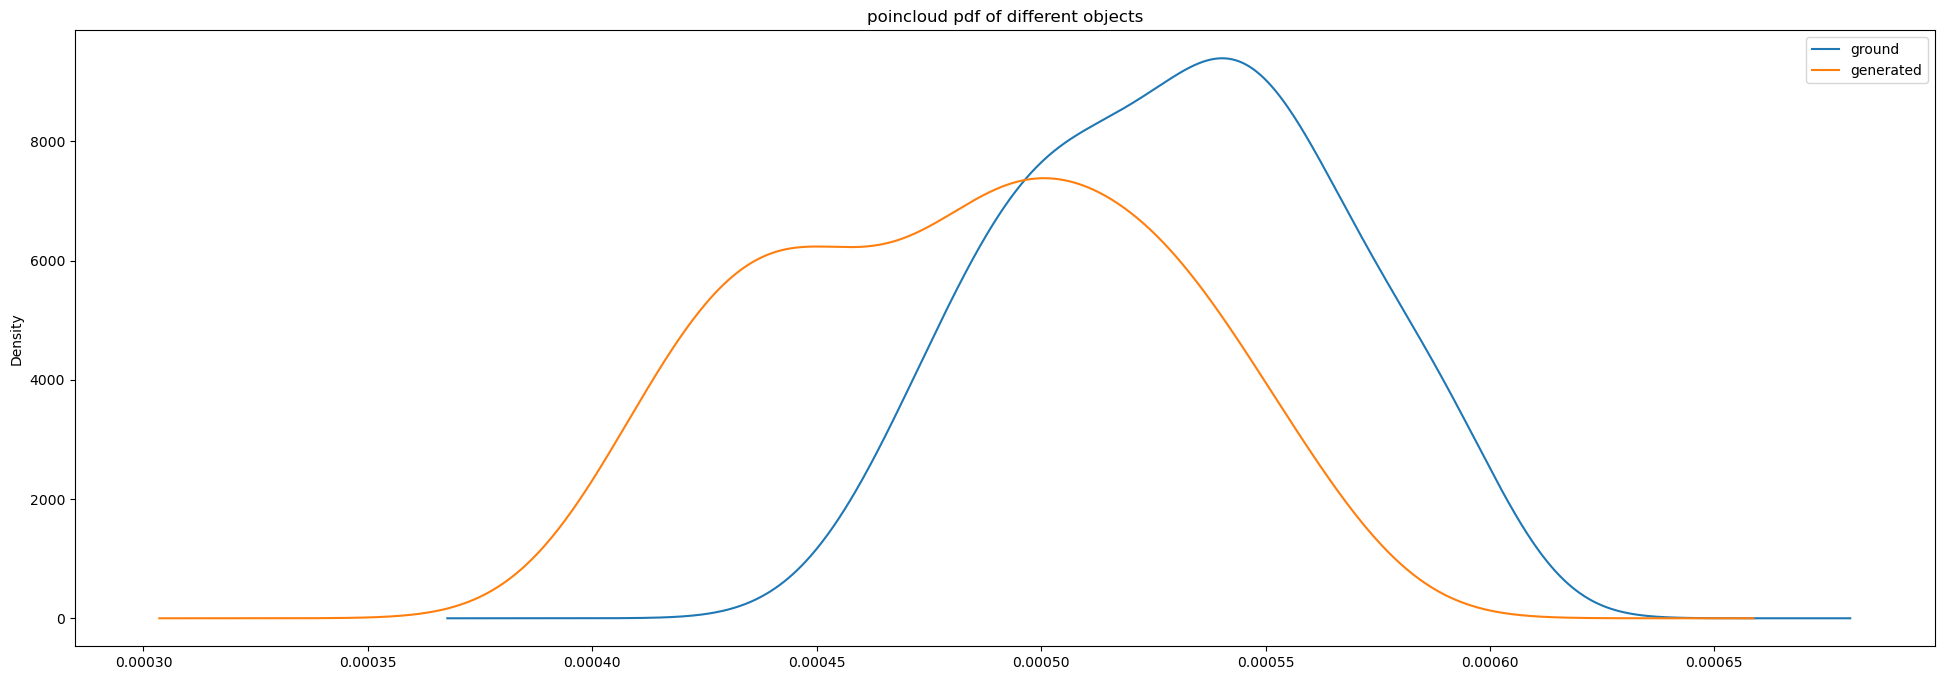

Clouds distance: 0.8828980220698668


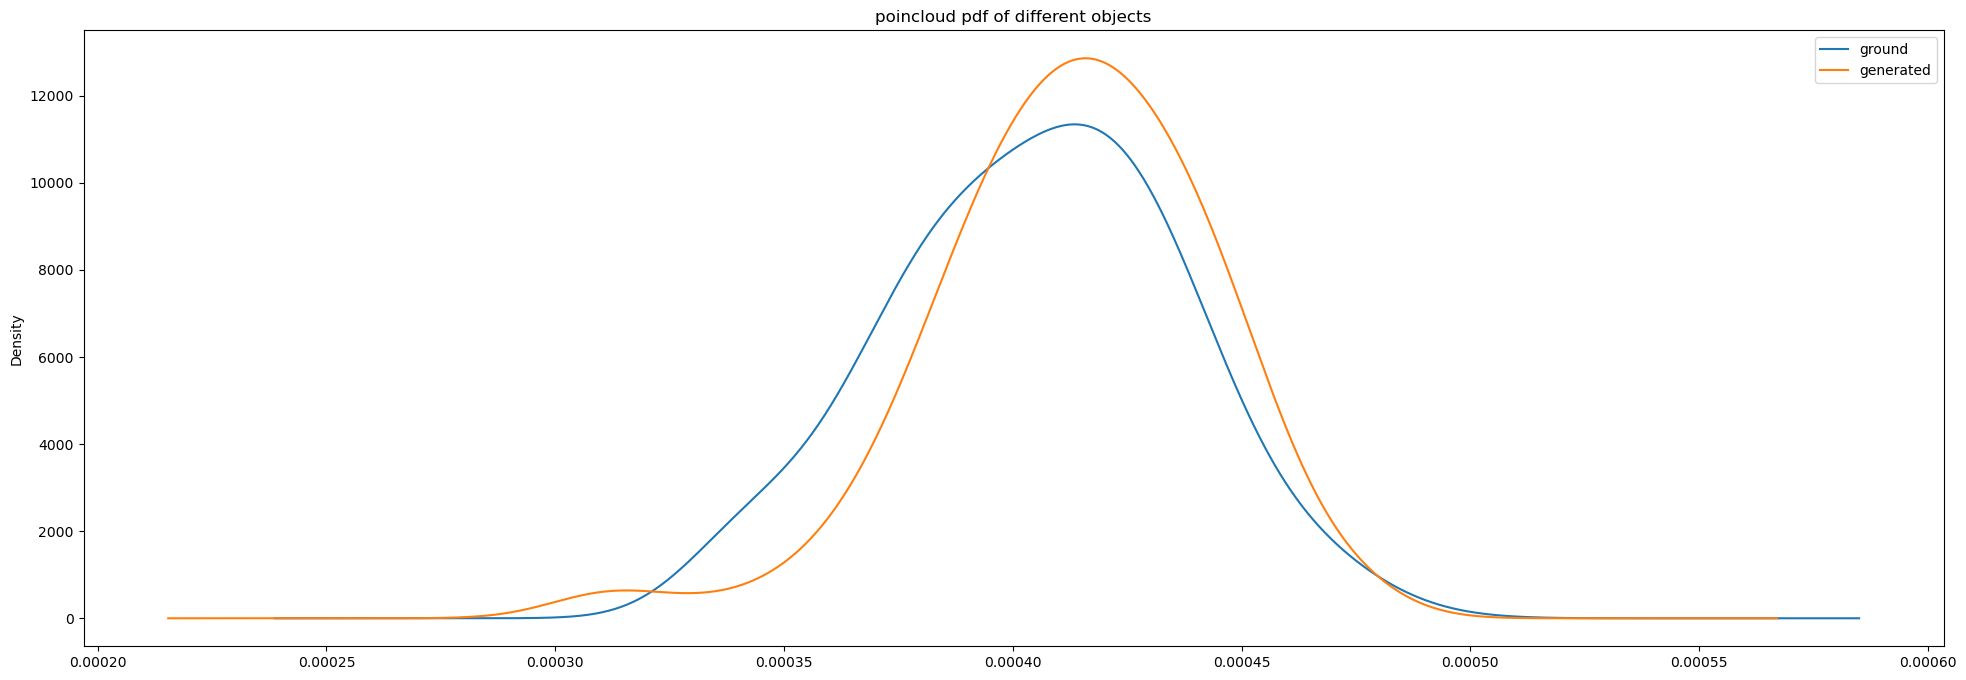

Clouds distance: 2.208709435791434


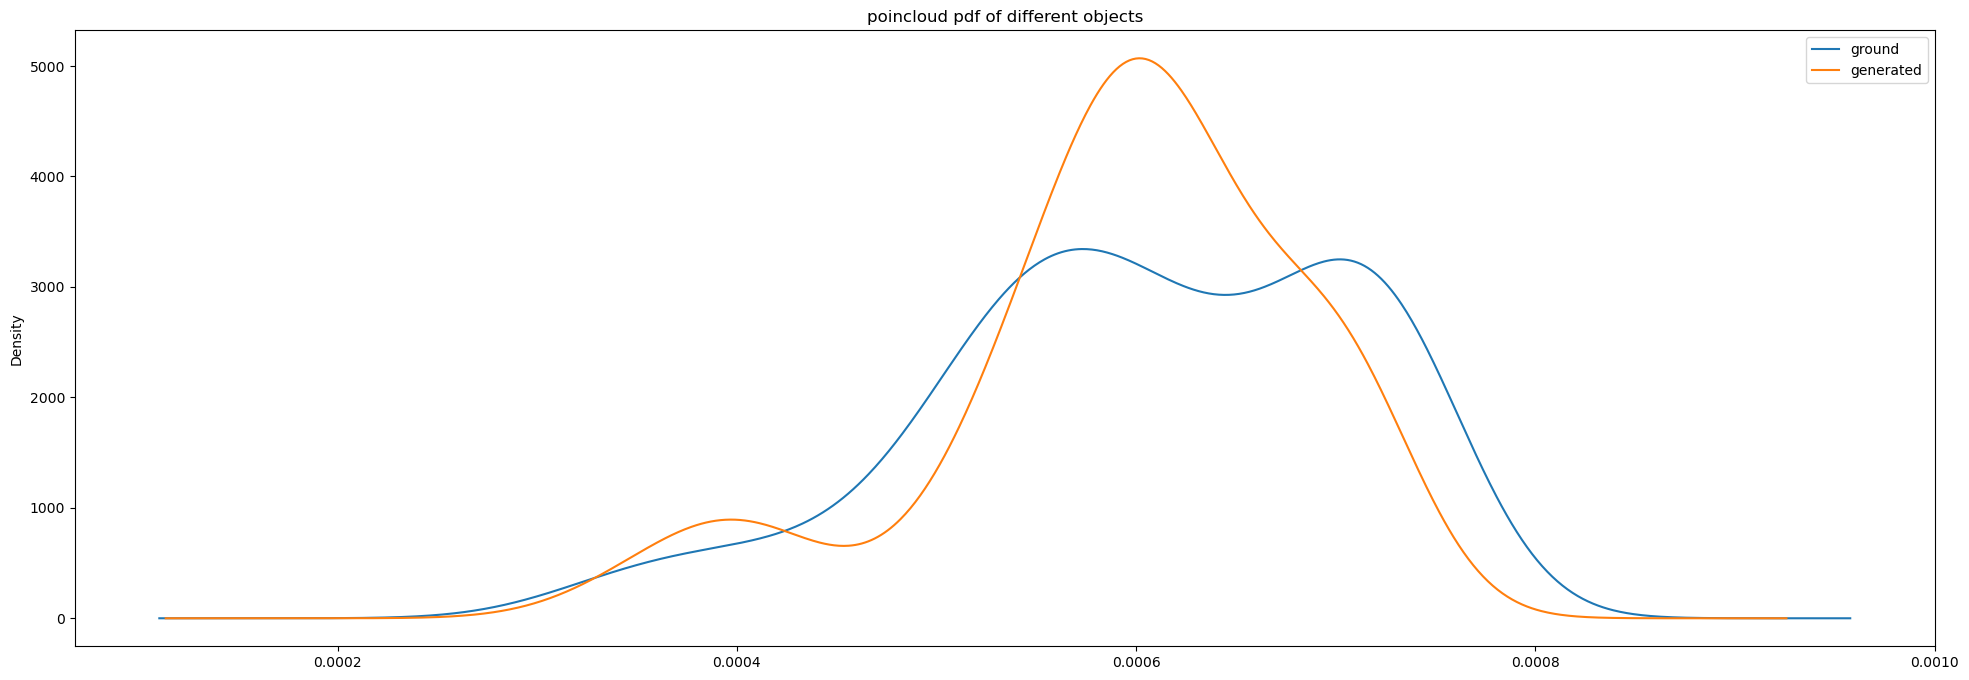

Clouds distance: 8.765303289948179


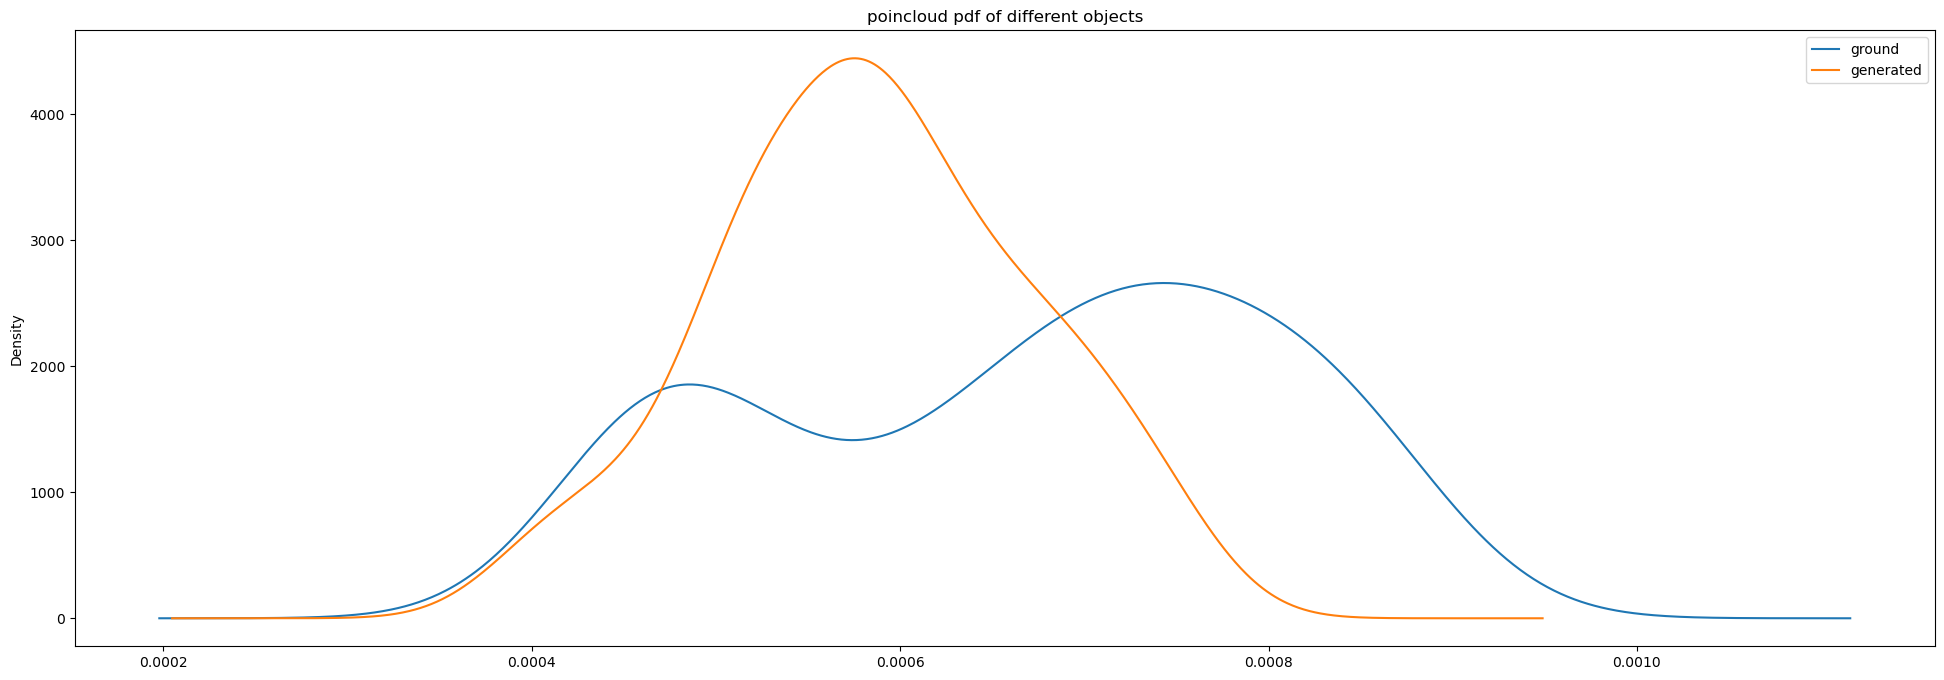

Clouds distance: 1.7144190579188034


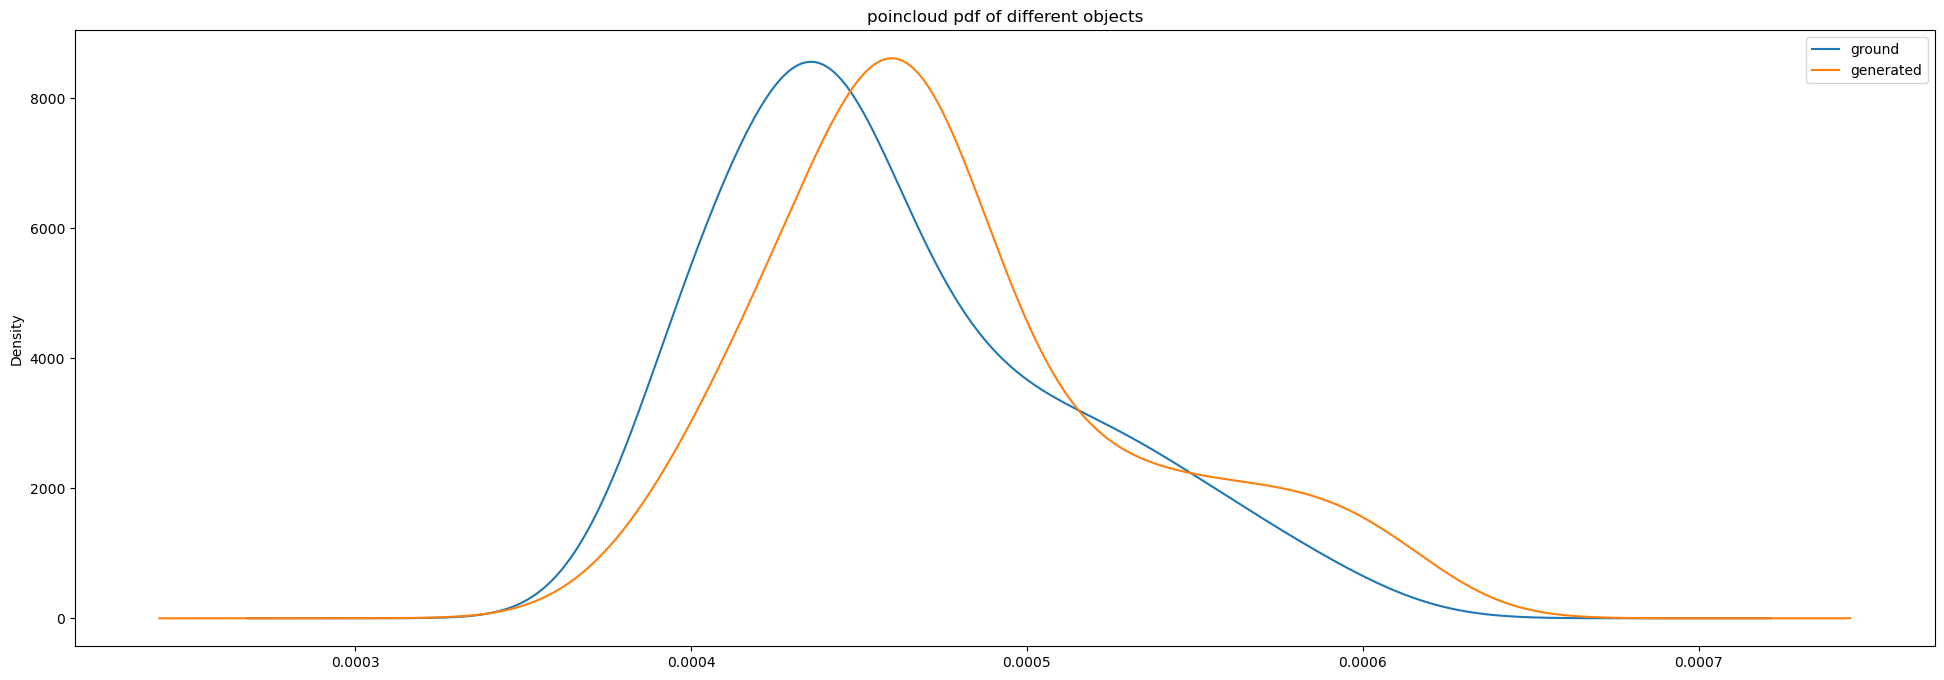

Clouds distance: 2.7557346484741174


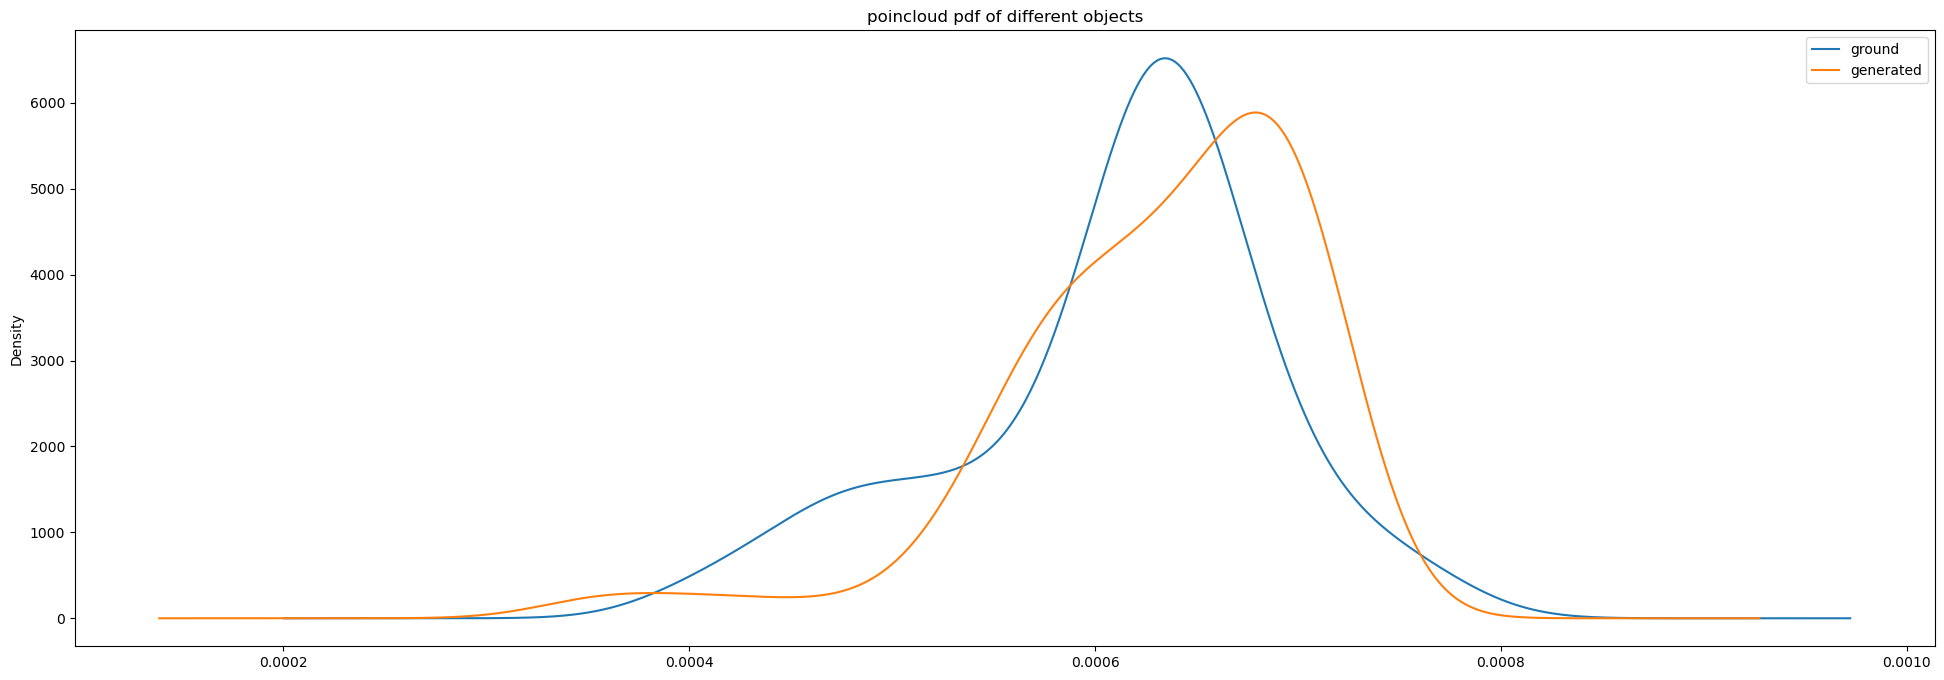

Clouds distance: 1.2347047110949916


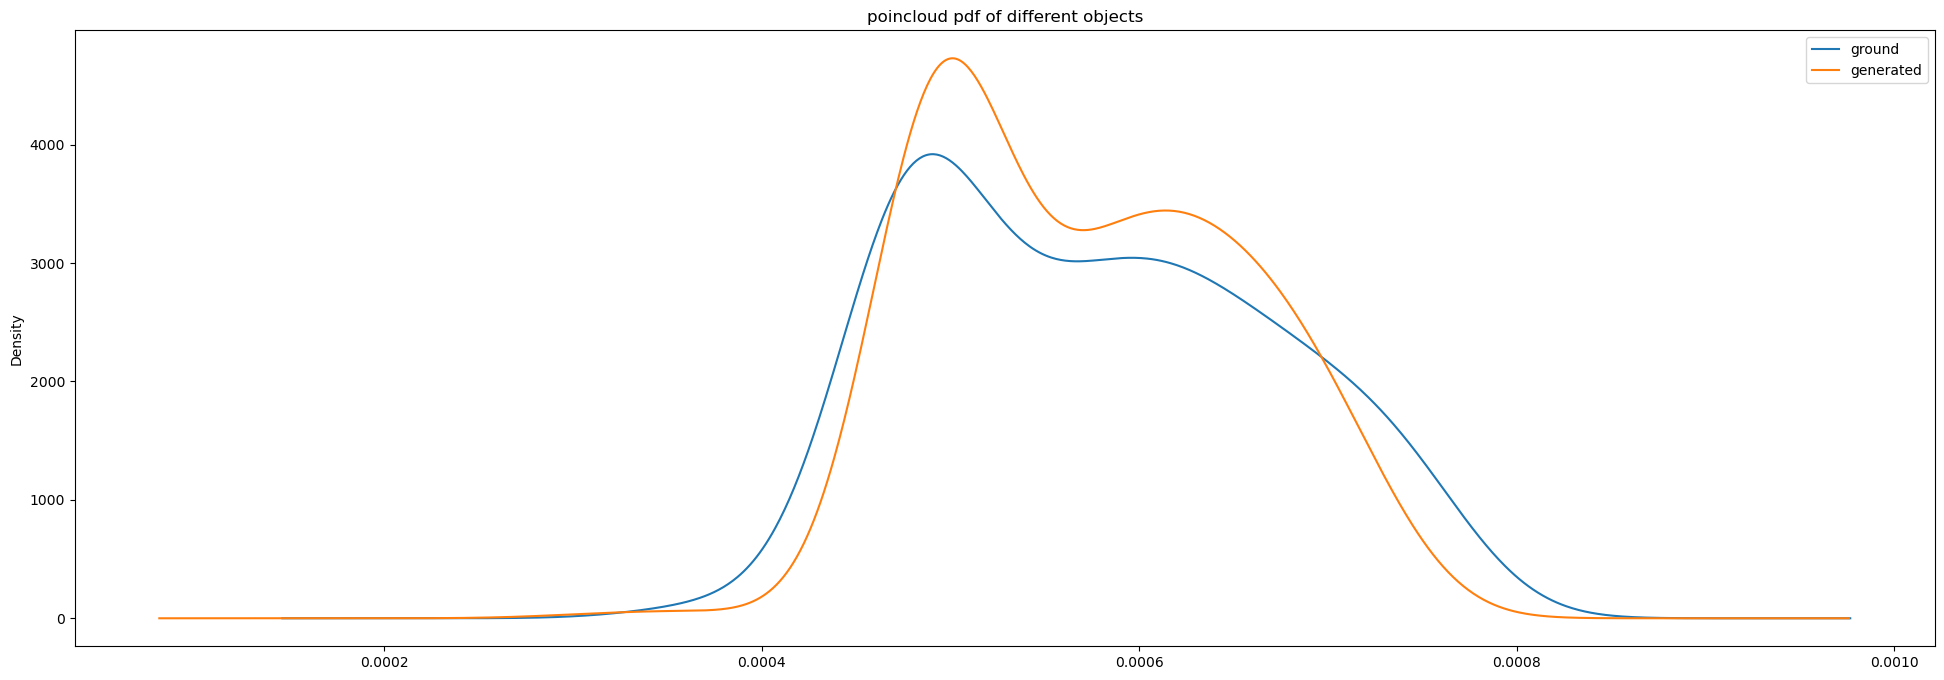

In [110]:
from sklearn.neighbors import KernelDensity
from scipy.stats import wasserstein_distance
import numpy as np

def cloud_distance(cloud1, cloud2, metric=None):
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    X1 = [float(1/i.sum()) for i in D1]
    X2 = [float(1/i.sum()) for i in D2]
    
    if metric == "gaussian":
        return np.mean(((np.mean(X1) - np.mean(X2))**2).sum()) / (np.std(X1)**2 + np.std(X2)**2)
    else:
        return wasserstein_distance(X1, X2) * 1e5

def plot_distributions(cloud1, cloud2, labels=["cloud1", "cloud2"]):
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    
    s = pd.DataFrame({
        labels[0]: [float(1/i.sum()) for i in D1],
        labels[1]: [float(1/i.sum()) for i in D2],
      })
    s.plot.kde(bw_method=0.4, figsize=(24,8), title='poincloud pdf of different objects')
    
    y_axis = ax1.axes.get_yaxis()
    y_axis.set_visible(False)
    plt.show()
    
for i in range(ground_point_clouds.shape[0]):

    j = i

    print("Clouds distance: {}".format(
        cloud_distance(torch.Tensor(ground_point_clouds[i]), torch.Tensor(pointe_point_clouds[j]))
    ))

    plot_distributions(
        torch.Tensor(ground_point_clouds[i]), 
        torch.Tensor(pointe_point_clouds[j]), 
        ["ground", "generated"]
    )